In this script we try to reproduce the results from ".\enso_project.jl\scripts\train_and_validate_esn.ipynb" without performing a TDE on the input data.

In [3]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [4]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

We use the SST Anomaly Index data with following data split: 80% training data | 10% validation data | 10% test data

In [29]:
# read input data into dictionary
data = Dict()

data["full"] = CSV.read("data/sst_data/sst_34_anomaly_embedded.txt", DataFrame; delim=',', ignorerepeated=true, header=false)
data["train_data_80"] = CSV.read("data/sst_34_data_split_80/train_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["test_data_80"] = CSV.read("data/sst_34_data_split_80/test_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["val_data_80"] = CSV.read("data/sst_34_data_split_80/val_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)

# bring into correct format
data["full"] = Matrix(transpose(Matrix(data["full"])))[1:1,1:end]
data["train_data_80"] = Matrix(transpose(Matrix(data["train_data_80"])))
data["test_data_80"] = Matrix(transpose(Matrix(data["test_data_80"])))
data["val_data_80"] = Matrix(transpose(Matrix(data["val_data_80"])))

data

Dict{Any, Any} with 4 entries:
  "full"          => [0.08 -0.2 … -0.84 -0.69]
  "train_data_80" => [0.08 -0.2 … 0.43 0.75]
  "val_data_80"   => [0.63 0.51 … 0.86 0.9]
  "test_data_80"  => [0.67 0.71 … -0.84 -0.69]

### Set hyperparameters

In [21]:
# set up universal parameter options of parameter grid
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.12]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [130, 138, 150]
param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_80)

162

### Train network

In [22]:
# network training
esn_80, W_out_80, val_loss_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(130, 0.8, 0.05, 0.1, 0.0)
Validation loss = 53.01450334986313
enso_project.ESNHyperparams(138, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.28279812841804
enso_project.ESNHyperparams(130, 1.0, 0.05, 0.1, 0.0)
Validation loss = 32.566272189723286
enso_project.ESNHyperparams(138, 1.0, 0.1, 0.1, 0.0)
Validation loss = 17.531449031286126
enso_project.ESNHyperparams(138, 1.0, 0.1, 0.1, 1.0e-6)
Validation loss = 16.22465136627405


(ESN(1 => 138), OutputLayer successfully trained with output size: 1, 16.22465136627405)

The validation loss is less than in the case with TDE (16.22 vs 30.42)

### Plot prediction

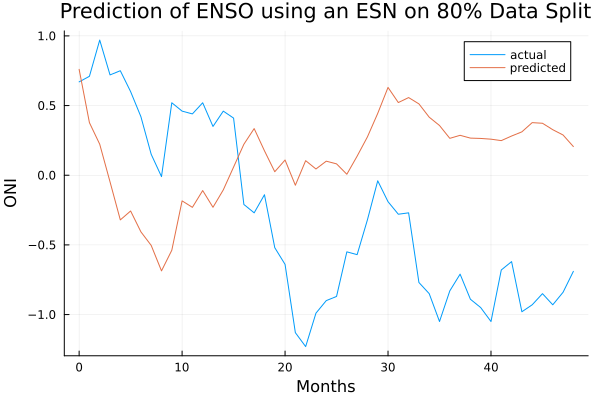

In [6]:
# plot against test data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "80% Data Split")

The prediction abilities are worse than with the TDE.

### Plot against train and val data

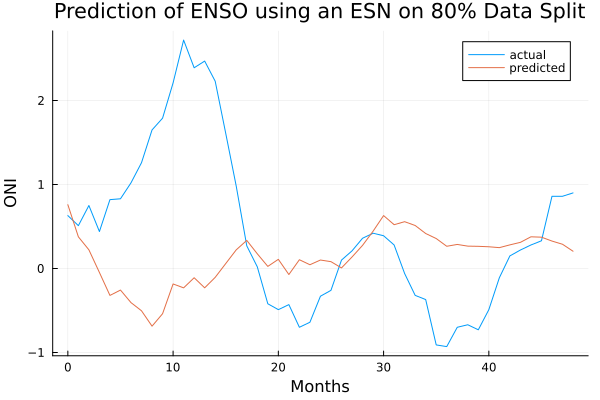

In [13]:
# plot against validation data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["val_data_80"], "80% Data Split")

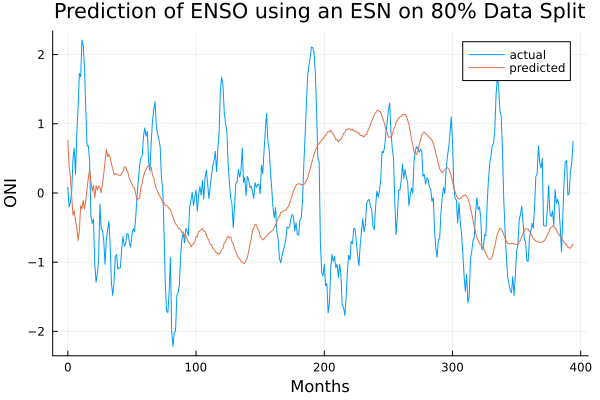

In [14]:
# plot against training data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["train_data_80"], "80% Data Split")

### Evaluation of prediction accuracy

In [15]:
model_prediction = enso_project.esn_eval_pred(esn_80, W_out_80, data["test_data_80"])
model_prediction = transpose(reshape(model_prediction,length(model_prediction),1))

1×49 transpose(::Matrix{Float64}) with eltype Float64:
 0.759788  0.377158  0.222371  -0.0474948  …  0.326681  0.288635  0.205584

In [16]:
#true_data = data["test_data_80"]
true_data = transpose(reshape(data["test_data_80"], length(data["test_data_80"]),1))

1×49 transpose(::Matrix{Float64}) with eltype Float64:
 0.67  0.71  0.97  0.72  0.75  0.6  …  -0.93  -0.85  -0.93  -0.84  -0.69

We plot the absolute difference between forecast and true data. We use an error threshold of 0.1.

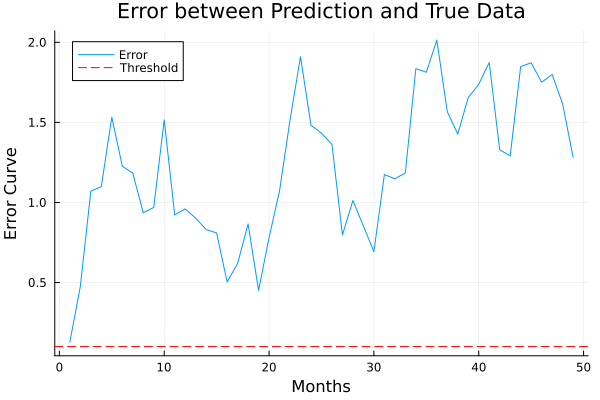

In [17]:
errors = enso_project.forecast_δ_1D(model_prediction, true_data, "abs")
enso_project.plot_error_curve(errors, 0.1)

### Start prediction from later time steps

note: previous validation set starts at index 398. Test set starts at index 444 (i.e. December)

In [23]:
# store predictions
predictions = zeros(6, size(data["test_data_80"], 2));

method: keep training set fixed, change franction of validation set to test set and retrain network

In [24]:
pectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.14, 0.2]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [110, 120, 125, 130, 135, 140, 150, 160]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [31]:
#Feb
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:446], param_grid)
predictions[1,1:size(data["full"][:, 447:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 447:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 37.57723111563688
enso_project.ESNHyperparams(160, 0.8, 0.05, 0.1, 0.0)
Validation loss = 36.01999453537931
enso_project.ESNHyperparams(140, 0.9, 0.05, 0.1, 0.0)
Validation loss = 35.158660173278854
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 31.533867252027484
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 13.145879689332451
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 12.763407130402776


In [32]:
#Apr
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:448], param_grid)
predictions[2,1:size(data["full"][:, 449:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 449:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 37.967954727860025
enso_project.ESNHyperparams(160, 0.8, 0.05, 0.1, 0.0)
Validation loss = 37.88429398972808
enso_project.ESNHyperparams(140, 0.9, 0.05, 0.1, 0.0)
Validation loss = 36.9972521208726
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 33.32762461389898
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 15.64590219339745
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 12.768778400387891


In [33]:
#Jun
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:450], param_grid)
predictions[3,1:size(data["full"][:, 451:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 451:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.06997193324981
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 34.20725620893768
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 17.948505394475337
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 12.805642521077512


In [34]:
#Aug
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:452], param_grid)
predictions[4,1:size(data["full"][:, 453:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 453:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.140787871456
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 34.31359607344651
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 19.09811339033593
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 12.838589391944657


In [35]:
#Oct
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:454], param_grid)
predictions[5,1:size(data["full"][:, 455:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 455:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.31670423466673
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 34.693803756095
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 19.88803874675963
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 13.338930317643586


In [36]:
#Dec
esn, W_out, val_loss = enso_project.cross_validate_esn(data["train_data_80"], data["full"][:, 398:456], param_grid)
predictions[6,1:size(data["full"][:, 457:end],2)] = enso_project.esn_eval_pred(esn, W_out, data["full"][:, 457:end]);

enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.35395335574567
enso_project.ESNHyperparams(110, 1.0, 0.05, 0.1, 0.0)
Validation loss = 35.600047234315255
enso_project.ESNHyperparams(125, 1.0, 0.05, 0.1, 0.0)
Validation loss = 20.832073027945267
enso_project.ESNHyperparams(130, 0.8, 0.05, 1.0, 0.0)
Validation loss = 14.694097819248531


In [38]:
predictions = predictions[:, 1:37] #make all same length
reference_data = data["full"][:, 457:end]

1×37 Matrix{Float64}:
 0.52  0.35  0.46  0.41  -0.21  -0.27  …  -0.93  -0.85  -0.93  -0.84  -0.69

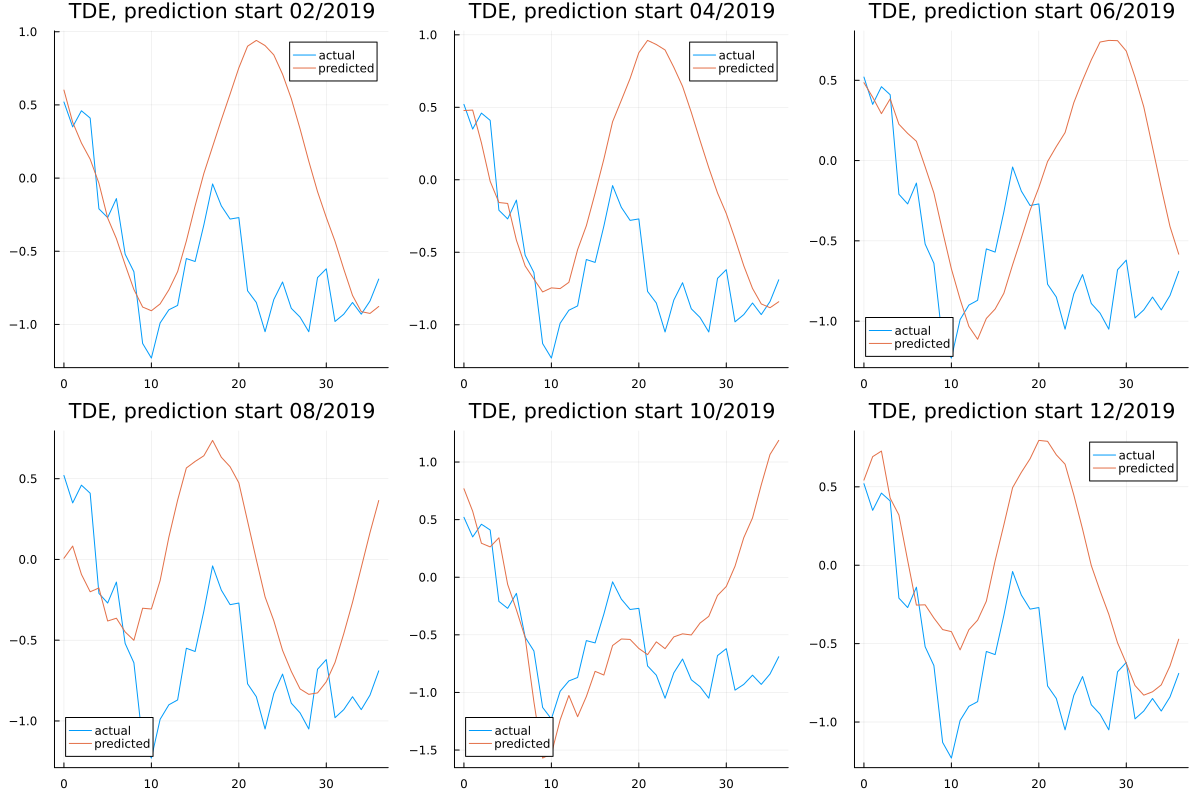

In [39]:
months = ["02/2019","04/2019","06/2019","08/2019","10/2019","12/2019"]
subplots = []
label = ["actual" "predicted"]
times =  collect(0:size(predictions,2))[1:end-1]
for i in eachindex(predictions[:,1])
    m = months[i]
    push!(subplots, plot(times, [reference_data[1,:], predictions[i, :]], label=label,  title="TDE, prediction start $m"))
end
plot(subplots..., layout=(2,3), size=(1200,800))